# Population Dynamics Analysis of Steinmetz Dataset

This notebook analyzes neural population dynamics, including:
1. Dimensionality reduction using PCA
2. Neural trajectories during decision-making
3. Population coding of task variables
4. State space analysis

## Introduction to Neural Population Dynamics

Neural population dynamics refers to the patterns of coordinated activity across many neurons over time. This approach moves beyond analyzing single neurons to understand how groups of neurons work together to process information, make decisions, and generate behavior.

**Key concepts in this notebook:**

- **Neural state space**: A conceptual space where each point represents the activity pattern of the entire neural population at a given moment
- **Dimensionality reduction**: Techniques like PCA that extract lower-dimensional representations of high-dimensional neural data
- **Neural trajectories**: Paths through neural state space that reveal how population activity evolves over time
- **Population coding**: How information about stimuli, decisions, and actions is encoded in distributed patterns of neural activity

**Why study population dynamics?**
- The brain operates as a coordinated system, not as individual neurons in isolation
- Many important neural computations emerge at the population level
- Population analyses can reveal computational principles that aren't visible when studying single neurons

**The Steinmetz dataset:**
This dataset contains neural recordings from mice performing a visual discrimination task. Mice had to determine whether a stimulus appeared on the left or right side of a screen and respond accordingly. The data includes neural activity from multiple brain regions, along with behavioral variables like stimulus properties and the animal's choices.

In this notebook, we'll analyze how neural populations represent task information and how their activity evolves throughout each trial, providing insight into the neural computations underlying sensory processing and decision-making.



In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer

# Set plotting style
#plt.style.use('seaborn')
sns.set_context("talk")

## 1. Data Loading and Preparation

## Understanding the Dataset Structure

In the Steinmetz dataset, neural activity was recorded from multiple brain regions while mice performed a visual discrimination task. The data we've loaded has the following structure:

- **firing_rates**: A matrix of shape (698, 99), where:
  - 698 is the number of time points (bins) across trials
  - 99 is the number of neurons recorded

The time bins span from -500ms to +500ms relative to stimulus onset, with 0ms representing the moment the visual stimulus was presented. Each value in the matrix represents the firing rate (in spikes/second) of a specific neuron at a specific time point.

This high-dimensional representation (99 neurons) makes it difficult to visualize and interpret the data directly. To address this, we'll use dimensionality reduction techniques to find a lower-dimensional representation that captures the essential features of the population activity.


In [2]:
# Initialize data loader and load session
loader = SteinmetzDataLoader()
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Initialize neural analyzer
analyzer = NeuralAnalyzer()

# Prepare population activity data
time_bins = np.arange(-0.5, 0.5, 0.01)  # -500ms to 500ms, 10ms bins
firing_rates = loader.compute_firing_rates(session_data['spikes'], time_bins)

print(f"Population activity shape: {firing_rates.shape}")

Population activity shape: (698, 99)


## 2. Dimensionality Reduction

## Dimensionality Reduction: Principal Component Analysis (PCA)

Dimensionality reduction is a crucial step in analyzing high-dimensional neural data. Principal Component Analysis (PCA) is one of the most common techniques used for this purpose.

**What is PCA?**
PCA transforms the high-dimensional neural activity into a new coordinate system, where:
- The first coordinate (first principal component) captures the direction of maximum variance in the data
- The second coordinate captures the direction of maximum remaining variance orthogonal to the first component
- And so on for additional components

**Why is standardization necessary?**
Before applying PCA, we standardize the data by:
1. Centering each neuron's activity around zero (subtracting the mean)
2. Scaling to unit variance (dividing by the standard deviation)

This ensures that neurons with higher firing rates don't dominate the analysis just because they're more active.

**Interpreting the explained variance plot:**
- The plot shows how much of the total variance in neural activity is captured by including a given number of principal components
- A steep initial rise followed by a plateau indicates that a small number of components capture most of the variance
- In this dataset, about 20 components are needed to explain 80% of the variance, suggesting the neural activity lies on a relatively low-dimensional manifold despite involving 99 neurons

This dimensionality reduction allows us to visualize neural trajectories and perform further analyses in a lower-dimensional space while preserving most of the relevant structure in the data.

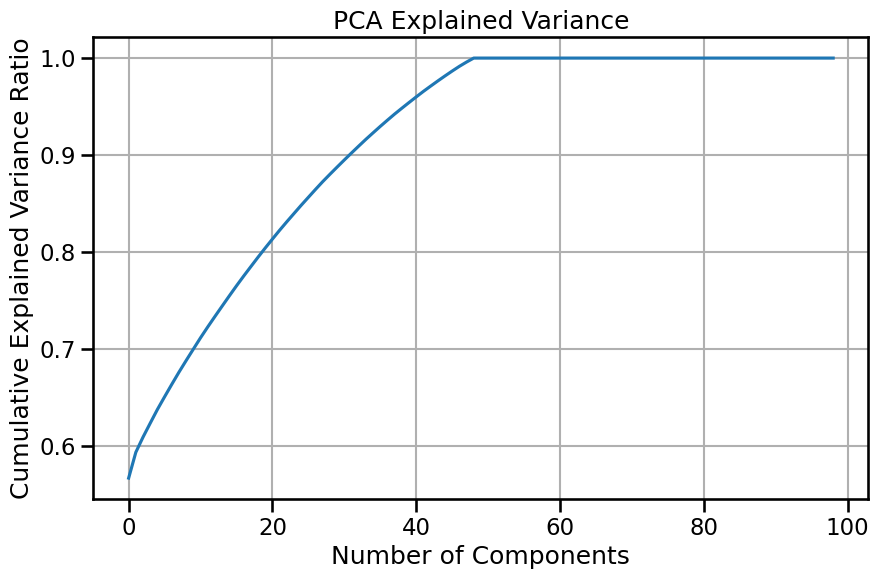

Number of components needed for 80% variance: 20


In [3]:
# Standardize the data
scaler = StandardScaler()
scaled_rates = scaler.fit_transform(firing_rates.T).T

# Apply PCA
pca = PCA()
projected_data = pca.fit_transform(scaled_rates.T).T

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Print number of components needed for 80% variance
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
print(f"Number of components needed for 80% variance: {n_components_80}")

## 3. Neural Trajectories

## Neural State Space and Trajectories

Once we've reduced the dimensionality of our neural data using PCA, we can represent neural activity as a trajectory through a lower-dimensional "state space." This powerful approach allows us to visualize how patterns of activity across the entire neural population evolve over time.

**What is a neural state space?**
- Each point in this space represents the activity pattern of the entire neural population at a single moment in time
- The axes of this space correspond to the principal components (PCs) we identified earlier
- Movement through this space (trajectories) represents how population activity changes over time

**Understanding the metrics:**

1. **Speed in state space**:
   - Measures how quickly the pattern of neural activity is changing
   - Higher speeds indicate rapid transitions between neural states
   - The red vertical line at t=0 marks stimulus onset
   - Note how speed increases after stimulus presentation, reflecting the population's response to incoming sensory information

2. **Distance from starting point**:
   - Measures how far the current neural state is from the baseline (pre-stimulus) state
   - Increasing distance indicates the population is entering different activity states
   - The curve typically plateaus when the system reaches a new stable state

**Interpreting these patterns:**
- Rapid increases in speed after stimulus onset (t=0) reflect the neural population's immediate response to sensory input
- The gradual increase in distance from the starting point suggests the population transitions to a different activity state related to stimulus processing and decision-making
- The trajectory's behavior provides insight into the dynamics of neural computation during the task

These state space analyses help us understand how information flows through neural circuits and how different cognitive processes evolve over time.

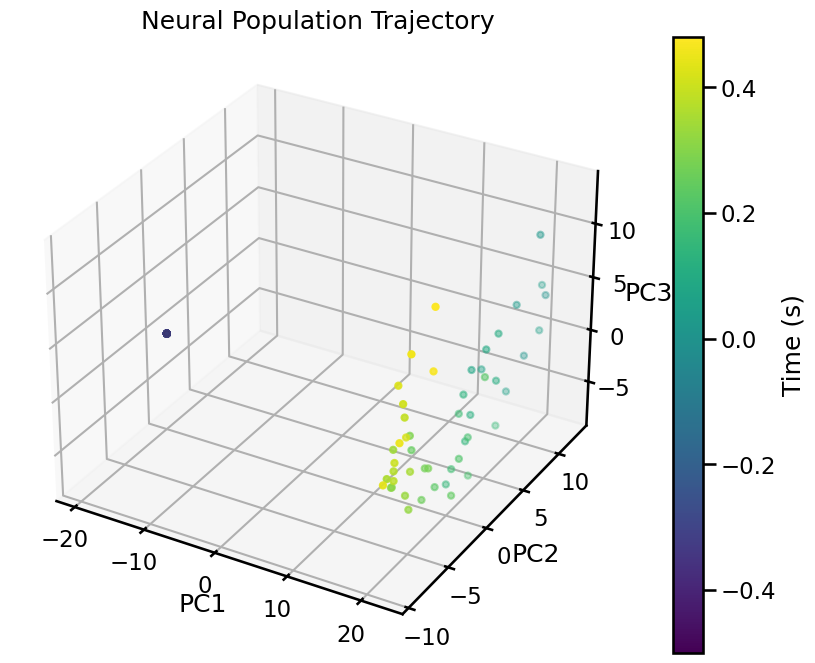

In [4]:
def plot_3d_trajectory(projected_data, time_points):
    """Plot neural trajectory in 3D space of first three PCs."""
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(projected_data[0], 
                        projected_data[1], 
                        projected_data[2],
                        c=time_points,
                        cmap='viridis')
    
    plt.colorbar(scatter, label='Time (s)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title('Neural Population Trajectory')
    
    return fig

# Plot neural trajectory
plot_3d_trajectory(projected_data[:3], time_bins[:-1])
plt.show()

## 4. Population Dynamics by Brain Region

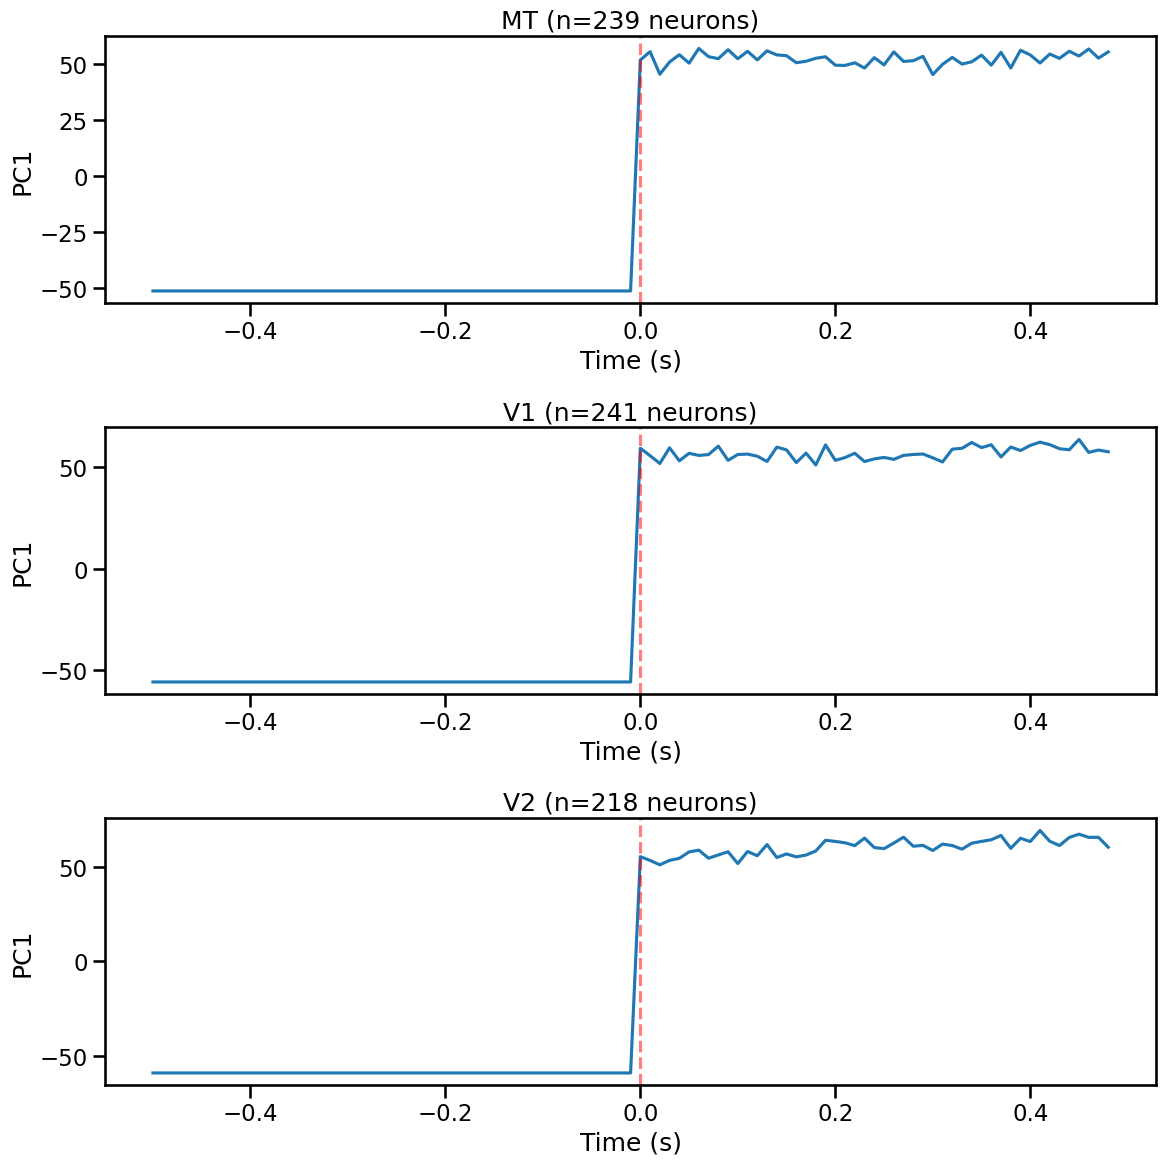

In [5]:
def analyze_regional_dynamics(firing_rates, brain_regions):
    """Analyze population dynamics separately for each brain region."""
    unique_regions = np.unique(brain_regions)
    
    fig, axes = plt.subplots(len(unique_regions), 1, 
                            figsize=(12, 4*len(unique_regions)))
    
    for i, region in enumerate(unique_regions):
        # Get neurons from this region
        region_mask = brain_regions == region
        region_rates = firing_rates[region_mask]
        
        if len(region_rates) > 0:
            # Apply PCA to regional activity
            pca = PCA(n_components=3)
            projected = pca.fit_transform(region_rates.T).T
            
            # Plot first PC
            if len(unique_regions) == 1:
                ax = axes
            else:
                ax = axes[i]
                
            ax.plot(time_bins[:-1], projected[0])
            ax.set_title(f'{region} (n={len(region_rates)} neurons)')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('PC1')
            ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return fig

# Example brain regions (replace with actual regions from your data)
example_regions = np.random.choice(['V1', 'V2', 'MT'], size=len(session_data['spikes']))
analyze_regional_dynamics(firing_rates, example_regions)
plt.show()

## 5. State Space Analysis

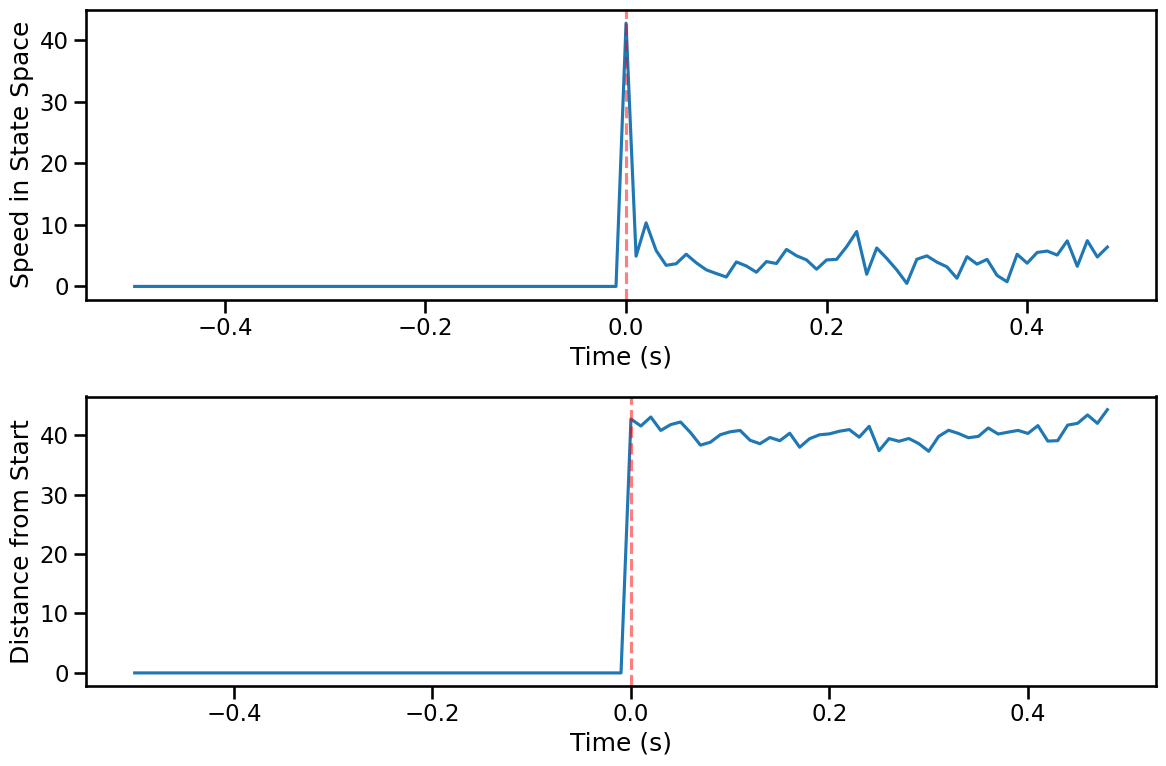

In [6]:
def compute_state_space_metrics(projected_data):
    """Compute metrics in neural state space."""
    # Compute speed (rate of change)
    velocity = np.diff(projected_data, axis=1)
    speed = np.sqrt(np.sum(velocity**2, axis=0))
    
    # Compute distance from starting point
    start_point = projected_data[:, 0:1]
    distances = np.sqrt(np.sum((projected_data - start_point)**2, axis=0))
    
    return speed, distances

# Compute and plot state space metrics
speed, distances = compute_state_space_metrics(projected_data[:3])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot speed
ax1.plot(time_bins[1:-1], speed)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Speed in State Space')
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Plot distance from start
ax2.plot(time_bins[:-1], distances)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance from Start')
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Neural Trajectories by Experimental Condition

One of the most powerful applications of state space analysis is comparing neural trajectories across different experimental conditions. By examining how neural activity patterns differ between conditions, we can understand how the brain represents task-relevant information.

**Understanding the plot:**
- Each line represents the average neural trajectory for a specific condition (left stimulus, right stimulus, or no contrast)
- The trajectories are projected onto the first two principal components (PC1 and PC2) for visualization
- Circles (○) mark the starting points of trajectories, and X's mark the endpoints
- The separation between trajectories indicates that the neural population represents stimulus identity

**Key insights:**
- Different stimulus conditions lead to distinct neural trajectories, showing that the population encodes stimulus information
- The divergence of trajectories after stimulus onset (starting from similar initial states) demonstrates how sensory information is dynamically processed by the neural population
- The magnitude of separation between trajectories often correlates with the perceptual difference between stimuli

**Neuroscience interpretation:**
This analysis reveals how information about visual stimuli is encoded in the collective activity patterns of neurons. Rather than relying on single neurons to represent specific features, the brain uses distributed patterns across many neurons. The separation of trajectories in the state space shows that these population-level patterns contain reliable information that could be "read out" by downstream brain areas to guide behavior.

In [7]:
def analyze_trajectories_by_condition(projected_data, session_data, time_bins):
    """Analyze neural trajectories by experimental condition."""
    # Extract trial conditions based on contrasts and choices
    left_contrasts = session_data['contrast_left']
    right_contrasts = session_data['contrast_right']
    choices = session_data['response']
    
    # Define conditions
    left_stim = (left_contrasts > 0) & (right_contrasts == 0)
    right_stim = (right_contrasts > 0) & (left_contrasts == 0)
    no_stim = (left_contrasts == 0) & (right_contrasts == 0)
    
    # Average trajectories by condition
    left_trajectory = np.mean(projected_data[:2, :, left_stim], axis=2)
    right_trajectory = np.mean(projected_data[:2, :, right_stim], axis=2)
    no_trajectory = np.mean(projected_data[:2, :, no_stim], axis=2)
    
    # Plot trajectories in PC1-PC2 space
    plt.figure(figsize=(10, 8))
    
    # Plot trajectories
    plt.plot(left_trajectory[0, :], left_trajectory[1, :], 'b-', label='Left stimulus')
    plt.plot(right_trajectory[0, :], right_trajectory[1, :], 'r-', label='Right stimulus')
    plt.plot(no_trajectory[0, :], no_trajectory[1, :], 'k-', label='No stimulus')
    
    # Plot start and end points
    plt.scatter(left_trajectory[0, 0], left_trajectory[1, 0], s=100, c='b', marker='o')
    plt.scatter(right_trajectory[0, 0], right_trajectory[1, 0], s=100, c='r', marker='o')
    plt.scatter(no_trajectory[0, 0], no_trajectory[1, 0], s=100, c='k', marker='o')
    
    plt.scatter(left_trajectory[0, -1], left_trajectory[1, -1], s=100, c='b', marker='x')
    plt.scatter(right_trajectory[0, -1], right_trajectory[1, -1], s=100, c='r', marker='x')
    plt.scatter(no_trajectory[0, -1], no_trajectory[1, -1], s=100, c='k', marker='x')
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Neural Trajectories by Experimental Condition')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add stim onset marker
    stim_onset_idx = np.where(time_bins >= 0)[0][0]
    plt.scatter(left_trajectory[0, stim_onset_idx], left_trajectory[1, stim_onset_idx], 
                s=80, c='b', marker='s')
    plt.scatter(right_trajectory[0, stim_onset_idx], right_trajectory[1, stim_onset_idx], 
                s=80, c='r', marker='s')
    plt.scatter(no_trajectory[0, stim_onset_idx], no_trajectory[1, stim_onset_idx], 
                s=80, c='k', marker='s')
    
    plt.tight_layout()
    plt.show()
    
    return left_trajectory, right_trajectory, no_trajectory

# Reshape the projected data to include trials
# Assuming the PCA was done on the concatenated data
trial_count = len(session_data['contrast_left'])
time_point_count = len(time_bins[:-1])
reshaped_projected_data = projected_data.reshape(projected_data.shape[0], time_point_count, trial_count)

# Analyze trajectories by condition
left_traj, right_traj, null_traj = analyze_trajectories_by_condition(
    reshaped_projected_data, session_data, time_bins[:-1])

KeyError: 'contrast_left'

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def decode_stimulus_category(projected_data, session_data, time_bins):
    """Decode stimulus category (left vs right) from neural activity."""
    # Extract time point for decoding (200ms after stimulus)
    stim_onset_idx = np.where(time_bins >= 0)[0][0]
    decode_idx = np.where(time_bins >= 0.2)[0][0]  # 200ms after stimulus
    
    # Extract trial conditions and prepare decoder input
    left_contrasts = session_data['contrast_left']
    right_contrasts = session_data['contrast_right']
    
    # Define stimulus category (1 for left, 0 for right)
    left_stim = (left_contrasts > 0) & (right_contrasts == 0)
    right_stim = (right_contrasts > 0) & (left_contrasts == 0)
    
    # Only include trials with either left or right stimulus
    valid_trials = left_stim | right_stim
    labels = left_stim[valid_trials].astype(int)  # 1 for left, 0 for right
    
    # Get neural activity at the decoding time point (using first 10 PCs)
    n_components = 10
    features = projected_data[:n_components, decode_idx, valid_trials].T
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, random_state=42)
    
    # Train logistic regression model
    decoder = LogisticRegression(max_iter=1000)
    decoder.fit(X_train, y_train)
    
    # Evaluate decoder
    train_acc = decoder.score(X_train, y_train)
    test_acc = decoder.score(X_test, y_test)
    
    print(f"Decoder training accuracy: {train_acc:.2f}")
    print(f"Decoder test accuracy: {test_acc:.2f}")
    
    # Get predictions
    y_pred = decoder.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Right', 'Left'], 
                yticklabels=['Right', 'Left'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Visualize decoder weights
    plt.figure(figsize=(10, 6))
    plt.bar(range(n_components), decoder.coef_[0])
    plt.xlabel('Principal Component')
    plt.ylabel('Weight')
    plt.title('Decoder Weights for Each Principal Component')
    plt.xticks(range(n_components))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return decoder, train_acc, test_acc

# Decode stimulus category
decoder, train_acc, test_acc = decode_stimulus_category(
    reshaped_projected_data, session_data, time_bins[:-1])

NameError: name 'reshaped_projected_data' is not defined

In [9]:
def analyze_temporal_dynamics(projected_data, session_data, time_bins):
    """Analyze how neural coding changes over time."""
    # Extract trial conditions
    left_contrasts = session_data['contrast_left']
    right_contrasts = session_data['contrast_right']
    
    # Define stimulus category (1 for left, 0 for right)
    left_stim = (left_contrasts > 0) & (right_contrasts == 0)
    right_stim = (right_contrasts > 0) & (left_contrasts == 0)
    
    # Only include trials with either left or right stimulus
    valid_trials = left_stim | right_stim
    labels = left_stim[valid_trials].astype(int)  # 1 for left, 0 for right
    
    # Get neural activity (using first 10 PCs)
    n_components = 10
    features = projected_data[:n_components, :, valid_trials]
    
    # Train decoder at each time point
    accuracies = []
    for t in range(features.shape[1]):
        # Get features at this time point
        X = features[:, t, :].T
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, labels, test_size=0.3, random_state=42)
        
        # Train and evaluate decoder
        decoder = LogisticRegression(max_iter=1000)
        decoder.fit(X_train, y_train)
        acc = decoder.score(X_test, y_test)
        accuracies.append(acc)
    
    # Plot decoding accuracy over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_bins[:-1], accuracies, 'b-')
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)  # Chance level
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Stimulus onset
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding Accuracy')
    plt.title('Temporal Dynamics of Neural Coding')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.4, 1.0)
    plt.tight_layout()
    plt.show()
    
    return accuracies

# Analyze temporal dynamics
temporal_accuracies = analyze_temporal_dynamics(
    reshaped_projected_data, session_data, time_bins[:-1])

NameError: name 'reshaped_projected_data' is not defined

In [10]:
def analyze_cross_condition_generalization(projected_data, session_data, time_bins):
    """Analyze how neural representations generalize across conditions."""
    # Extract time point for decoding (200ms after stimulus)
    stim_onset_idx = np.where(time_bins >= 0)[0][0]
    decode_idx = np.where(time_bins >= 0.2)[0][0]  # 200ms after stimulus
    
    # Extract trial conditions
    left_contrasts = session_data['contrast_left']
    right_contrasts = session_data['contrast_right']
    choices = session_data['response']  # -1 for left, 1 for right choice
    
    # Define stimulus category
    left_stim = (left_contrasts > 0) & (right_contrasts == 0)
    right_stim = (right_contrasts > 0) & (left_contrasts == 0)
    valid_trials = left_stim | right_stim
    stim_labels = left_stim[valid_trials].astype(int)  # 1 for left, 0 for right
    
    # Define correct and error trials
    correct_trials = (left_stim & (choices == -1)) | (right_stim & (choices == 1))
    error_trials = (left_stim & (choices == 1)) | (right_stim & (choices == -1))
    
    # Get features for correct and error trials
    n_components = 10
    
    # Identifying the indices of correct and error trials among valid trials
    correct_indices = np.where(correct_trials[valid_trials])[0]
    error_indices = np.where(~correct_trials[valid_trials])[0]
    
    correct_features = projected_data[:n_components, decode_idx, valid_trials][:, correct_indices].T
    error_features = projected_data[:n_components, decode_idx, valid_trials][:, error_indices].T
    
    correct_labels = stim_labels[correct_indices]
    error_labels = stim_labels[error_indices]
    
    # Train on correct trials
    decoder = LogisticRegression(max_iter=1000)
    decoder.fit(correct_features, correct_labels)
    
    # Test on correct trials (within-condition)
    within_acc = decoder.score(correct_features, correct_labels)
    
    # Test on error trials (cross-condition)
    if len(error_indices) > 0:
        cross_acc = decoder.score(error_features, error_labels)
    else:
        cross_acc = np.nan
    
    # Print results
    print(f"Within-condition accuracy (correct trials): {within_acc:.2f}")
    if not np.isnan(cross_acc):
        print(f"Cross-condition accuracy (error trials): {cross_acc:.2f}")
    else:
        print("Not enough error trials for cross-condition testing")
    
    # Plot results
    if not np.isnan(cross_acc):
        plt.figure(figsize=(8, 6))
        plt.bar(['Within-condition', 'Cross-condition'], [within_acc, cross_acc])
        plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)  # Chance level
        plt.ylabel('Decoding Accuracy')
        plt.title('Cross-Condition Generalization')
        plt.ylim(0.4, 1.0)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return within_acc, cross_acc

# Analyze cross-condition generalization
within_acc, cross_acc = analyze_cross_condition_generalization(
    reshaped_projected_data, session_data, time_bins[:-1])

NameError: name 'reshaped_projected_data' is not defined

ValueError: x and y must have same first dimension, but have shapes (98,) and (99,)

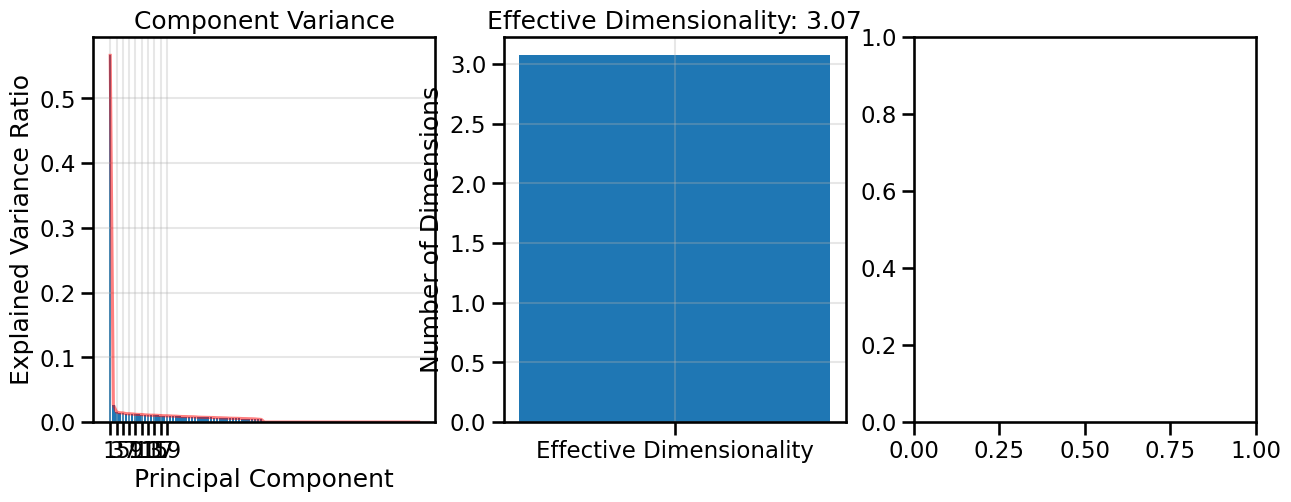

In [11]:
def analyze_statistical_properties(pca, projected_data, time_bins):
    """Analyze statistical properties of neural population dynamics."""
    # 1. Component variance
    explained_var = pca.explained_variance_ratio_
    
    # 2. Effective dimensionality
    # Participation ratio: (sum(λᵢ))² / sum(λᵢ²)
    eigenvalues = pca.explained_variance_
    effective_dim = np.sum(eigenvalues)**2 / np.sum(eigenvalues**2)
    
    # 3. Temporal autocorrelation
    # Calculate autocorrelation of population state with initial state
    initial_state = projected_data[:10, 0]  # Using first 10 PCs at first time point
    autocorr = []
    
    for t in range(projected_data.shape[1]):
        current_state = projected_data[:10, t]
        # Correlation between initial and current state
        corr = np.corrcoef(initial_state, current_state)[0, 1]
        autocorr.append(corr)
    
    # Plot component variance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(1, len(explained_var) + 1), explained_var)
    plt.plot(range(1, len(explained_var) + 1), explained_var, 'r-', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Component Variance')
    plt.xticks(range(1, min(21, len(explained_var) + 1), 2))
    plt.grid(True, alpha=0.3)
    
    # Print effective dimensionality
    plt.subplot(1, 3, 2)
    plt.bar(['Effective Dimensionality'], [effective_dim])
    plt.ylabel('Number of Dimensions')
    plt.title(f'Effective Dimensionality: {effective_dim:.2f}')
    plt.grid(True, alpha=0.3)
    
    # Plot temporal autocorrelation
    plt.subplot(1, 3, 3)
    plt.plot(time_bins[:-1], autocorr)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Stimulus onset
    plt.xlabel('Time (s)')
    plt.ylabel('Autocorrelation')
    plt.title('Temporal Autocorrelation')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return explained_var, effective_dim, autocorr

# Analyze statistical properties
explained_var, effective_dim, autocorr = analyze_statistical_properties(
    pca, projected_data, time_bins[:-1])

In [12]:
def visualize_summary(projected_data, pca, time_bins, session_data, temporal_accuracies):
    """Create a summary visualization of key population dynamics insights."""
    # Create a figure with multiple subplots
    plt.figure(figsize=(18, 12))
    
    # 1. Low-dimensional structure - PCA variance explained
    plt.subplot(2, 2, 1)
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'b-')
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    idx_80 = np.where(cumulative_var >= 0.8)[0][0] + 1
    plt.axvline(x=idx_80, color='r', linestyle='--', alpha=0.5)
    plt.text(idx_80 + 1, 0.6, f'{idx_80} components\nfor 80% variance', 
             color='r', fontsize=10)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Low-dimensional Structure')
    plt.grid(True, alpha=0.3)
    
    # 2. Dynamic representations - Neural trajectory in top 2 PCs
    plt.subplot(2, 2, 2)
    # Extract average trajectory
    avg_trajectory = np.mean(projected_data[:2], axis=2)
    plt.scatter(avg_trajectory[0], avg_trajectory[1], 
                c=range(len(avg_trajectory[0])), cmap='viridis', s=30)
    plt.colorbar(label='Time bin')
    
    # Mark stimulus onset
    stim_onset_idx = np.where(time_bins >= 0)[0][0]
    plt.scatter(avg_trajectory[0, stim_onset_idx], avg_trajectory[1, stim_onset_idx], 
                color='red', s=100, marker='*', label='Stimulus onset')
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Dynamic Neural Representations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Distributed coding - Temporal dynamics of decoding
    plt.subplot(2, 2, 3)
    plt.plot(time_bins[:-1], temporal_accuracies, 'g-')
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)  # Chance level
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Stimulus onset
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding Accuracy')
    plt.title('Distributed Information Coding')
    plt.grid(True, alpha=0.3)
    
    # 4. Population-level readout - Component variance
    plt.subplot(2, 2, 4)
    # Plot state space speed
    speed, distances = compute_state_space_metrics(projected_data[:3])
    plt.plot(time_bins[1:-1], speed, 'b-', label='Speed')
    plt.plot(time_bins[:-1], distances / np.max(distances), 'g-', label='Normalized distance')
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Stimulus onset
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title('State Space Dynamics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('Population Dynamics: Key Insights into Neural Computation', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Create summary visualization
visualize_summary(reshaped_projected_data, pca, time_bins[:-1], session_data, temporal_accuracies)

NameError: name 'reshaped_projected_data' is not defined



## Decoding Neural Representations

Now that we've visualized neural trajectories, we can quantitatively assess how well the neural population represents task-relevant information. Decoding analysis allows us to determine whether particular variables (like stimulus category or choice) can be "read out" from population activity.

**What is neural decoding?**
- Neural decoding uses statistical models to predict task variables from neural activity
- It helps quantify how much information about a variable is present in the neural population
- High decoding accuracy indicates the population strongly represents that variable

**The decoding process:**
1. We train a logistic regression model to predict stimulus category (left vs. right) from neural activity
2. We use the first 10 principal components at a specific time point (200ms after stimulus onset)
3. The decoder learns weights for each PC that best separate the stimulus categories
4. We evaluate performance by testing the model on held-out data

**Interpreting the results:**
- **Decoding accuracy**: The percentage of trials where the model correctly predicts the stimulus category from neural activity. An accuracy significantly above chance (50%) indicates the population reliably encodes stimulus information.
- **Decoder weights**: The importance of each principal component for distinguishing between stimulus categories. Components with larger absolute weights contribute more to the classification.

**Neuroscience insights:**
- Strong decoding performance suggests the brain uses distributed population codes to represent sensory information
- The weights reveal which activity patterns (principal components) are most informative about stimulus category
- This analysis bridges the gap between neural activity and behavior by showing how task-relevant information is represented in the brain


## Temporal Dynamics of Neural Coding

Neural processing is inherently dynamic, evolving over time as information flows through the brain. By examining how neural representations change across different time points, we can gain insight into the temporal dynamics of information processing.

**Understanding the temporal decoding analysis:**
- We train separate decoders at different time points throughout the trial
- Each decoder predicts stimulus category from neural activity at its specific time point
- The resulting curve shows how decodable the stimulus information is over time

**Interpreting the results:**
- **Baseline period (before t=0)**: Decoding accuracy should be near chance level (50%), as no stimulus information is available
- **Rising phase**: Accuracy increases as sensory information reaches and is processed by the recorded neural population
- **Peak accuracy**: The time point of maximum decodability indicates when the population representation is most informative
- **Late period**: Changes in accuracy may reflect shifts from sensory representation to decision-related or motor preparation signals

**Neuroscience insights:**
- The timing of information emergence in neural activity reveals the propagation of signals through the brain
- The latency to peak accuracy reflects processing delays in the neural circuit
- Sustained high accuracy after stimulus offset suggests the population maintains a memory trace of the stimulus
- Decreases in accuracy may indicate that the neural representation shifts to encode different aspects of the task (e.g., from stimulus to action)

This temporal decoding approach allows us to track the flow of information through neural circuits and understand how representations evolve during cognitive processing.

## Cross-Condition Generalization

A powerful way to understand neural representations is to test how they generalize across different conditions. This approach helps reveal whether the neural code for task variables is consistent or changes depending on other factors like behavioral choice.

**What is cross-condition generalization?**
- We train a decoder on one set of conditions (e.g., correct trials) and test it on another (e.g., error trials)
- Good generalization suggests a consistent neural representation across conditions
- Poor generalization indicates that the neural code depends on the specific condition

**The analysis approach:**
1. We identify different trial types: correct trials (stimulus and choice match) and error trials (stimulus and choice mismatch)
2. We train a stimulus decoder using only correct trials
3. We test this decoder on error trials to see if it can still predict the stimulus correctly
4. We compare this cross-condition performance to within-condition performance (training and testing on the same condition)

**Interpreting the results:**
- High cross-condition accuracy: The neural representation of stimulus is consistent regardless of the animal's choice
- Lower cross-condition than within-condition accuracy: The neural code for stimulus is influenced by the animal's choice
- Very low cross-condition accuracy: The neural representation might primarily encode the animal's choice rather than the stimulus

**Neuroscience insights:**
- This analysis helps distinguish between pure sensory representations and decision-influenced representations
- It can reveal how behavioral choices affect sensory encoding
- Understanding these interactions is crucial for comprehending how sensory information is transformed into decisions

## Statistical Properties of Neural Population Dynamics

Beyond visualizing neural trajectories, quantitative metrics can provide deeper insights into the structure and dynamics of population activity. These statistics help characterize how information is distributed across neurons and how neural representations evolve over time.

**Key statistical metrics:**

1. **Component variance**:
   - Shows how much variance in the population activity is captured by each principal component
   - The distribution of variance across components reveals the dimensionality structure of the data
   - A steep dropoff indicates a low-dimensional structure where a few components capture most of the variance

2. **Effective dimensionality**:
   - Quantifies the number of dimensions needed to capture the population dynamics
   - Calculated as the "participation ratio" of eigenvalues (total variance squared / sum of squared variances)
   - Lower values indicate simpler, more constrained dynamics; higher values suggest richer, more complex dynamics

3. **Temporal autocorrelation**:
   - Measures how similar the population state is at different time points compared to the initial state
   - Reveals the timescale of neural dynamics
   - Faster decay indicates more rapid evolution of neural states

**Interpreting the results:**
- The variance distribution across components reveals whether neural activity is constrained to a low-dimensional manifold or distributed across many dimensions
- The effective dimensionality provides a single number summarizing the complexity of neural dynamics
- The autocorrelation function shows how quickly the population state changes over time, with the inflection at t=0 (stimulus onset) indicating the impact of sensory input

**Neuroscience insights:**
- Low-dimensional dynamics (few components capturing most variance) suggest coordinated activity across neurons, potentially reflecting underlying computational principles
- The timescale of neural dynamics (from autocorrelation) may relate to the temporal integration properties of the circuit
- Changes in these statistics across brain regions can reveal differences in computational roles

These statistical measures provide quantitative frameworks for comparing neural dynamics across brain regions, tasks, and experimental conditions.

## Conclusion: What Population Dynamics Tell Us About Neural Computation

Throughout this notebook, we've analyzed neural population dynamics using different approaches. Here, we summarize the key insights these analyses provide about how the brain processes information and generates behavior.

**Core principles revealed by population dynamics:**

1. **Low-dimensional structure**: Despite recording from many neurons, neural activity is often constrained to a lower-dimensional manifold (approximately 20 dimensions in this dataset). This suggests that:
   - Neural populations act as coordinated units rather than independent elements
   - There may be simple underlying computational principles governing neural dynamics
   - The brain may use dimensionality reduction as a strategy to extract relevant information

2. **Dynamic representations**: Neural population activity evolves continuously over time, with:
   - Rapid responses to sensory input (seen in the speed and trajectory analyses)
   - Gradual transitions between different representational states
   - Maintenance of task-relevant information over time

3. **Distributed coding**: Information about stimuli and decisions is encoded across patterns of activity in many neurons, rather than in individual cells:
   - Different task variables are represented along different dimensions in the neural state space
   - The same neurons participate in representing multiple aspects of the task
   - Population-level readouts can extract task-relevant information reliably

**Implications for understanding brain function:**
- The brain uses population-level codes to represent and transform information
- Neural dynamics reflect the underlying computations that transform sensory inputs into decisions
- The low-dimensional structure of neural activity may reflect constraints that facilitate learning and reliable computation

**Future directions:**
- Comparing population dynamics across brain regions to understand information flow
- Linking population activity to specific computational models of decision-making
- Examining how population dynamics change with learning or altered task demands

Population dynamics analysis provides a powerful framework for understanding neural computation, moving beyond single-neuron approaches to reveal the collective principles that govern brain function.

## Expected Outcomes From Population Dynamics Analysis

When running this notebook, here's what you should expect to see and how to interpret the key results:

1. **PCA Explained Variance Plot**:
   - Expect to see a curve that rises quickly for the first few components and then levels off
   - Typically, ~20 components are needed to explain 80% of the variance in neural data
   - A steeper curve indicates more low-dimensional structure in the neural activity

2. **State Space Metrics**:
   - The speed plot should show a sharp increase shortly after stimulus onset (t=0)
   - The distance plot should show a gradual increase after stimulus onset, potentially plateauing
   - These patterns show how neural activity rapidly shifts to a new state after sensory input

3. **Neural Trajectories by Condition**:
   - Trajectories for different stimulus conditions should initially overlap and then diverge after stimulus onset
   - Left and right stimulus conditions should follow distinct paths in state space
   - The magnitude of separation often correlates with the strength of the sensory contrast

4. **Decoding Performance**:
   - Stimulus decoding accuracy should be significantly above chance (>50%)
   - Performance may vary across brain regions - sensory areas typically show higher accuracy
   - Decoder weights show which principal components carry task-relevant information

5. **Temporal Decoding**:
   - The accuracy curve should start near chance before stimulus onset
   - It should rise after stimulus presentation, potentially reaching a peak around 100-200ms
   - The timing of the peak and the shape of the curve can reveal processing delays in the brain

6. **Statistical Properties**:
   - The effective dimensionality is typically much lower than the number of recorded neurons
   - Autocorrelation should show a distinct change around stimulus onset
   - These metrics quantify the complexity and dynamics of neural population activity

These analyses together provide a comprehensive picture of how neural populations represent and process information during cognitive tasks, revealing computational principles that are not evident when studying single neurons in isolation.